# **Setting Up the Environment** 🛠️

---


In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [10]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau ,  ModelCheckpoint

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
from glob import glob
from sklearn.utils.class_weight import compute_class_weight

In [14]:
import pandas as pd 

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,classification_report

In [16]:
import seaborn as sns
import random

In [17]:
import json

# **Define dataset paths** 🛠️

---


In [18]:
# Define dataset paths
BASE_DIR = r"..\data\processed\split_faces"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# **Create data generators** 🛠️

---


In [ ]:
def create_data_generator(data_dir, img_size=(299, 299), batch_size=32, train=True):
    """
    Creates an ImageDataGenerator for a given dataset.

    Returns:
        generator: The ImageDataGenerator instance.
    """
    if train:
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,  # InceptionV3 preprocessing
            rotation_range=20,  
            width_shift_range=0.1,                    # Max 10% shift horizontally
            height_shift_range=0.1,                   # Max 10% shift vertically
            horizontal_flip=True,                     # Mirror effect (only if dataset allows)
            brightness_range=[0.8, 1.2],            # Small brightness variations
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle = train
    )
    

    print(f"✅ Data generator created for: {data_dir} | Train mode: {train}")
    return generator


In [14]:
# Create generators
train_gen = create_data_generator(TRAIN_DIR, train=True)
val_gen = create_data_generator(VAL_DIR, train=False)
test_gen = create_data_generator(TEST_DIR, train=False)

# Get number of classes from train_gen
num_classes = len(train_gen.class_indices)
print(f"Number of classes: {num_classes}")

Found 14015 images belonging to 105 classes.
✅ Data generator created for: ..\data\processed\split_faces\train | Train mode: True
Found 1708 images belonging to 105 classes.
✅ Data generator created for: ..\data\processed\split_faces\val | Train mode: False
Found 1853 images belonging to 105 classes.
✅ Data generator created for: ..\data\processed\split_faces\test | Train mode: False
Number of classes: 105


In [12]:
train_gen.class_indices

{'pins_Adriana Lima': 0,
 'pins_Alex Lawther': 1,
 'pins_Alexandra Daddario': 2,
 'pins_Alvaro Morte': 3,
 'pins_Amanda Crew': 4,
 'pins_Andy Samberg': 5,
 'pins_Anne Hathaway': 6,
 'pins_Anthony Mackie': 7,
 'pins_Avril Lavigne': 8,
 'pins_Ben Affleck': 9,
 'pins_Bill Gates': 10,
 'pins_Bobby Morley': 11,
 'pins_Brenton Thwaites': 12,
 'pins_Brian J. Smith': 13,
 'pins_Brie Larson': 14,
 'pins_Chris Evans': 15,
 'pins_Chris Hemsworth': 16,
 'pins_Chris Pratt': 17,
 'pins_Christian Bale': 18,
 'pins_Cristiano Ronaldo': 19,
 'pins_Danielle Panabaker': 20,
 'pins_Dominic Purcell': 21,
 'pins_Dwayne Johnson': 22,
 'pins_Eliza Taylor': 23,
 'pins_Elizabeth Lail': 24,
 'pins_Emilia Clarke': 25,
 'pins_Emma Stone': 26,
 'pins_Emma Watson': 27,
 'pins_Gwyneth Paltrow': 28,
 'pins_Henry Cavil': 29,
 'pins_Hugh Jackman': 30,
 'pins_Inbar Lavi': 31,
 'pins_Irina Shayk': 32,
 'pins_Jake Mcdorman': 33,
 'pins_Jason Momoa': 34,
 'pins_Jennifer Lawrence': 35,
 'pins_Jeremy Renner': 36,
 'pins_Jessic

In [ ]:
# with open(r"..\models\labels.json", 'w') as f:
#         json.dump(train_gen.class_indices, f)
# print(f"✅ Class indices saved to '..\models\labels.json'")

✅ Class indices saved to '..\models\class_indices.json'


In [33]:
# Reverse the dictionary to map indices to class names
reversed_class_indices = {int(v): k for k, v in train_gen.class_indices.items()}

# Save the reversed mapping
with open(r"..\models\labels.json", "w") as f:
    json.dump(reversed_class_indices, f)


print(f"✅ Reverse class indices saved to '..\models\labels.json'")

✅ Reverse class indices saved to '..\models\labels.json'


In [34]:
with open(r"..\models\labels.json", 'r') as f:
        test_json = json.load(f)

In [35]:
test_json

{'0': 'pins_Adriana Lima',
 '1': 'pins_Alex Lawther',
 '2': 'pins_Alexandra Daddario',
 '3': 'pins_Alvaro Morte',
 '4': 'pins_Amanda Crew',
 '5': 'pins_Andy Samberg',
 '6': 'pins_Anne Hathaway',
 '7': 'pins_Anthony Mackie',
 '8': 'pins_Avril Lavigne',
 '9': 'pins_Ben Affleck',
 '10': 'pins_Bill Gates',
 '11': 'pins_Bobby Morley',
 '12': 'pins_Brenton Thwaites',
 '13': 'pins_Brian J. Smith',
 '14': 'pins_Brie Larson',
 '15': 'pins_Chris Evans',
 '16': 'pins_Chris Hemsworth',
 '17': 'pins_Chris Pratt',
 '18': 'pins_Christian Bale',
 '19': 'pins_Cristiano Ronaldo',
 '20': 'pins_Danielle Panabaker',
 '21': 'pins_Dominic Purcell',
 '22': 'pins_Dwayne Johnson',
 '23': 'pins_Eliza Taylor',
 '24': 'pins_Elizabeth Lail',
 '25': 'pins_Emilia Clarke',
 '26': 'pins_Emma Stone',
 '27': 'pins_Emma Watson',
 '28': 'pins_Gwyneth Paltrow',
 '29': 'pins_Henry Cavil',
 '30': 'pins_Hugh Jackman',
 '31': 'pins_Inbar Lavi',
 '32': 'pins_Irina Shayk',
 '33': 'pins_Jake Mcdorman',
 '34': 'pins_Jason Momoa',
 

In [164]:
def plot_sample_images(generator, num_images=9):
    """
    Plots sample images from a given data generator.
    
    Args:
        generator: Keras ImageDataGenerator instance.
        num_images (int): Number of images to display (default: 9).
    """
    # Get a batch of images and labels
    images, labels = next(generator)

    print("Min pixel value:", np.min(images))
    print("Max pixel value:", np.max(images))

    images = ((images + 1) / 2)*255  # Reverse the transformation

    # images = np.clip((images + 1) * 127.5, 0, 255).astype(np.uint8)
    
    # Convert labels to class names
    class_indices = {v: k for k, v in generator.class_indices.items()}
    label_names = [class_indices[np.argmax(label)] for label in labels]
    
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))  # Convert to valid image format
        plt.title(f"Class: {label_names[i]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Min pixel value: -1.0
Max pixel value: 1.0


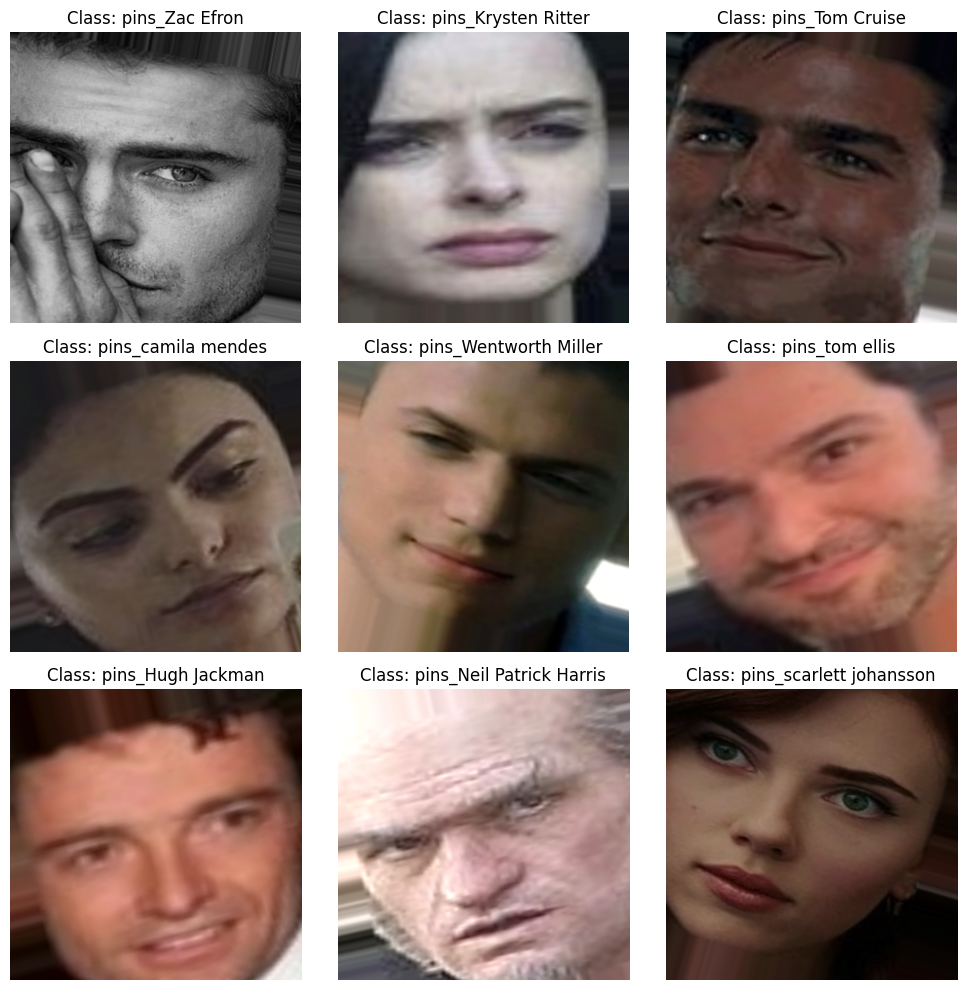

In [95]:
# Plot sample images with augmentation
plot_sample_images(train_gen)

In [96]:
# Get a batch of data
batch_images, batch_labels = next(train_gen)  # train_generator from ImageDataGenerator

# Print shapes
print("Batch Images Shape:", batch_images.shape)  # (batch_size, 299, 299, 3)
print("Batch Labels Shape:", batch_labels.shape)  # (batch_size, num_classes) for one-hot

# Print first few labels
print("Sample Labels:", batch_labels[0])

Batch Images Shape: (32, 299, 299, 3)
Batch Labels Shape: (32, 105)
Sample Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [97]:
# Get class names (subdirectories representing different people or classes)
class_names = os.listdir(TRAIN_DIR)
class_names.sort()  # Make sure they're sorted

# Create an empty list to store all the labels
labels = []

# Count the number of images per class (person)
for i, class_name in enumerate(class_names):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_folder):
        # Count image files (adjust extensions as needed)
        image_files = glob(os.path.join(class_folder, '*.jpg')) + glob(os.path.join(class_folder, '*.png'))
        num_samples = len(image_files)
        labels.extend([i] * num_samples)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(zip(np.unique(labels), class_weights))

In [98]:
display(class_weights_dict)

{0: 0.7851540616246498,
 1: 1.1123015873015873,
 2: 0.7415343915343915,
 3: 1.191751700680272,
 4: 1.4352278545826933,
 5: 0.8501668183196845,
 6: 0.8188723342097575,
 7: 1.3347619047619048,
 8: 1.0346991509782208,
 9: 1.3347619047619048,
 10: 1.3760432007854688,
 11: 1.2134199134199135,
 12: 0.799258625605931,
 13: 1.647854203409759,
 14: 0.9814425770308123,
 15: 1.0111832611832612,
 16: 1.0427827380952381,
 17: 0.9534013605442176,
 18: 1.0851722802942314,
 19: 1.6895720313441833,
 20: 0.9269179894179894,
 21: 1.1506568144499179,
 22: 1.191751700680272,
 23: 1.0427827380952381,
 24: 1.0593348450491307,
 25: 0.7945011337868481,
 26: 1.2024882024882024,
 27: 0.7945011337868481,
 28: 0.8898412698412699,
 29: 0.8501668183196845,
 30: 0.9399731723675385,
 31: 1.3215464403583215,
 32: 1.0764208909370199,
 33: 1.0509936257967754,
 34: 0.9018661518661518,
 35: 0.9269179894179894,
 36: 0.996090973702914,
 37: 1.191751700680272,
 38: 1.4508281573498965,
 39: 0.9205254515599344,
 40: 1.419959473

In [99]:
def build_inception_model(num_classes, learning_rate=0.001, fine_tune=False):
    """
    Builds and compiles an InceptionV3 model for face recognition.
    Returns:
        model (tf.keras.Model): Compiled Keras model.
    """
    # Load InceptionV3 with pre-trained ImageNet weights, excluding the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    
    # Freeze base model layers if not fine-tuning
    base_model.trainable = fine_tune

    # Add custom classification layers
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
    # x = Dense(128, activation='relu')(x)  # Fully connected layer
    # x = Dropout(0.5)(x)  # Regularization


    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduces spatial dimensions
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)  # Normalize activations
    x = Dropout(0.5)(x)  # Reduce overfitting

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # x = Dense(256, activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    

    output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [100]:
def plot_training_history(history):

    plt.figure(figsize=(18, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [101]:
num_classes = len(train_gen.class_indices)  # Get number of classes
print(num_classes)

105


In [ ]:
num_classes = len(train_gen.class_indices)  # Get number of classes
model = build_inception_model(num_classes)  # Build model

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_190 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv2d_188 False
2 batch_normalization_190 False
3 activation_188 False
4 conv2d_189 False
5 batch_normalization_191 False
6 activation_189 False
7 conv2d_190 False
8 batch_normalization_192 False
9 activation_190 False
10 max_pooling2d_8 False
11 conv2d_191 False
12 batch_normalization_193 False
13 activation_191 False
14 conv2d_192 False
15 batch_normalization_194 False
16 activation_192 False
17 max_pooling2d_9 False
18 conv2d_196 False
19 batch_normalization_198 False
20 activation_196 False
21 conv2d_194 False
22 conv2d_197 False
23 batch_normalization_196 False
24 batch_normalization_199 False
25 activation_194 False
26 activation_197 False
27 average_pooling2d_18 False
28 conv2d_193 False
29 conv2d_195 False
30 conv2d_198 False
31 conv2d_199 False
32 batch_normalization_195 False
33 batch_normalization_197 False
34 batch_normalization_200 False
35 batch_normalization_201 False
36 activation_193 False
37 activation_195 False
38 activation_198 False
39 activation

In [ ]:
# model = tf.keras.models.load_model(r"..\models\best_model.h5")

In [102]:
def train_model(model, train_generator, val_generator,class_weights, epochs=20):
    """
    Train the CNN model with early stopping and learning rate reduction.

    Returns:
        history: Training history object.
    """

    # Callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6
    )

    # Model checkpoint - saves the best model based on val_loss
    checkpoint_callback = ModelCheckpoint(
        filepath=r"..\models\best_model.h5",  # Save in HDF5 format
        monitor="val_loss",        # Track validation loss instead of accuracy
        save_best_only=True,       # Save only the best model
        save_weights_only=False,   # Save the entire model, not just weights
        mode="min",                # Minimize val_loss
        verbose=1                  # Print save status
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr,checkpoint_callback],
        class_weight=class_weights,
        verbose=1
    )

    return history


In [ ]:
history_1 = train_model(model, train_gen, val_gen,class_weights=class_weights_dict, epochs=30) 

Epoch 1/30
438/438 [==============================] - ETA: 0s - loss: 4.3239 - accuracy: 0.0445
Epoch 1: val_loss improved from inf to 3.56525, saving model to ..\models\best_model.h5
438/438 [==============================] - 615s 1s/step - loss: 4.3239 - accuracy: 0.0445 - val_loss: 3.5653 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 2/30
438/438 [==============================] - ETA: 0s - loss: 3.7152 - accuracy: 0.1019
Epoch 2: val_loss improved from 3.56525 to 3.28192, saving model to ..\models\best_model.h5
438/438 [==============================] - 503s 1s/step - loss: 3.7152 - accuracy: 0.1019 - val_loss: 3.2819 - val_accuracy: 0.1639 - lr: 0.0010
Epoch 3/30
438/438 [==============================] - ETA: 0s - loss: 3.4800 - accuracy: 0.1323
Epoch 3: val_loss improved from 3.28192 to 3.14038, saving model to ..\models\best_model.h5
438/438 [==============================] - 580s 1s/step - loss: 3.4800 - accuracy: 0.1323 - val_loss: 3.1404 - val_accuracy: 0.1996 - lr: 0.0010
Epoch

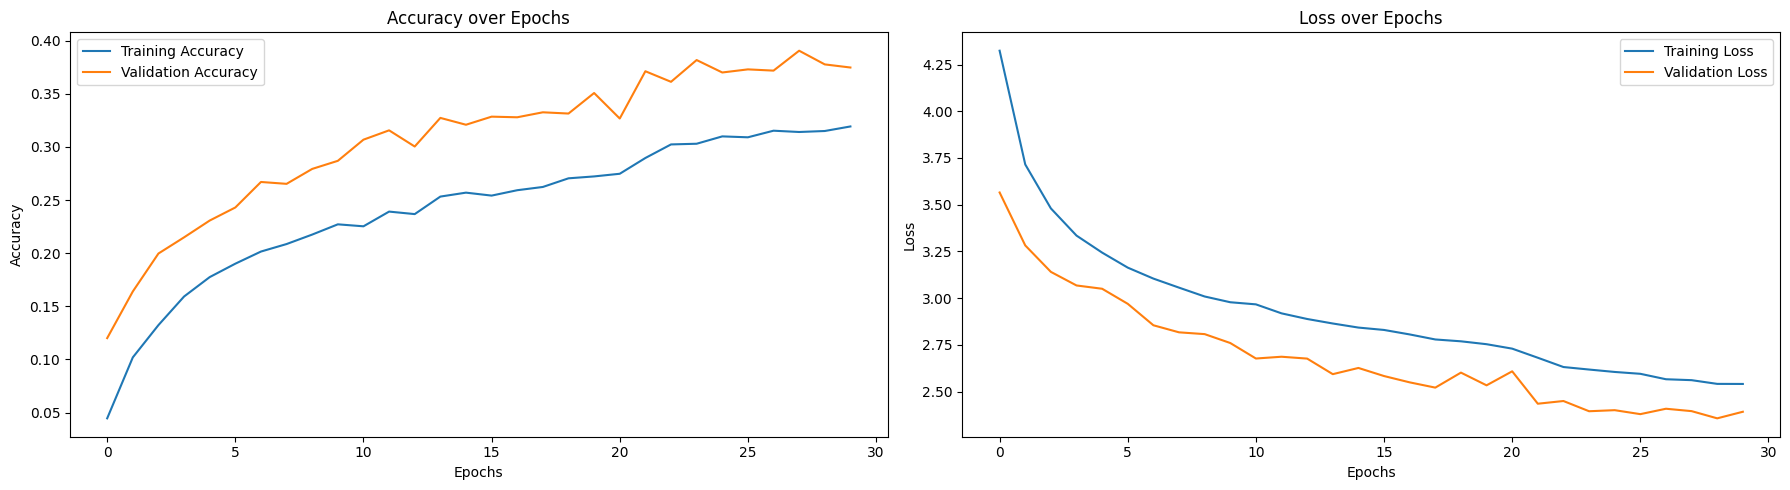

In [ ]:
plot_training_history(history_1.history)

In [ ]:
# Unfreeze the last few layers of the InceptionV3 model (e.g., the last 50 layers)
for layer in model.layers[-50:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2 = train_model(model, train_gen, val_gen,class_weights=class_weights_dict, epochs=30) 

Epoch 1/30
438/438 [==============================] - ETA: 0s - loss: 2.6854 - accuracy: 0.2891
Epoch 1: val_loss improved from inf to 2.33729, saving model to ..\models\best_model.h5
438/438 [==============================] - 494s 1s/step - loss: 2.6854 - accuracy: 0.2891 - val_loss: 2.3373 - val_accuracy: 0.3776 - lr: 5.0000e-05
Epoch 2/30
438/438 [==============================] - ETA: 0s - loss: 2.4621 - accuracy: 0.3344
Epoch 2: val_loss improved from 2.33729 to 2.22273, saving model to ..\models\best_model.h5
438/438 [==============================] - 405s 923ms/step - loss: 2.4621 - accuracy: 0.3344 - val_loss: 2.2227 - val_accuracy: 0.4157 - lr: 5.0000e-05
Epoch 3/30
438/438 [==============================] - ETA: 0s - loss: 2.3038 - accuracy: 0.3739
Epoch 3: val_loss improved from 2.22273 to 2.10816, saving model to ..\models\best_model.h5
438/438 [==============================] - 418s 953ms/step - loss: 2.3038 - accuracy: 0.3739 - val_loss: 2.1082 - val_accuracy: 0.4350 - lr

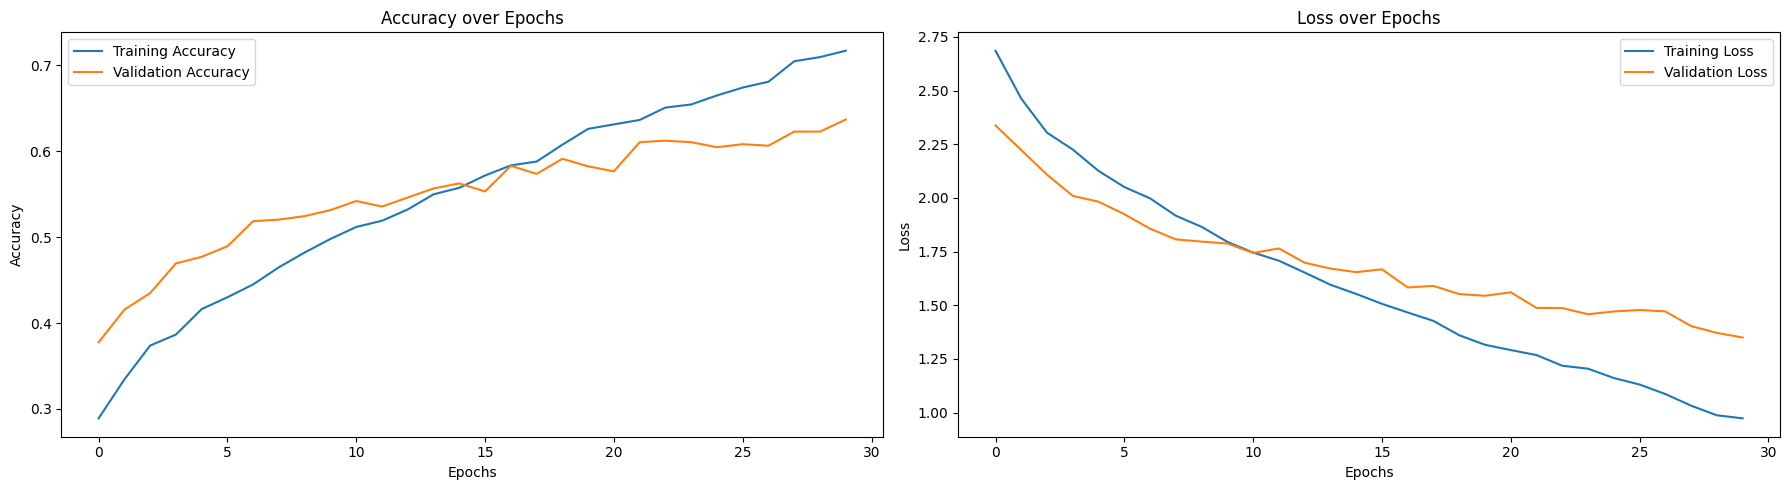

In [ ]:
plot_training_history(history_2.history)

In [ ]:
history_3 = train_model(model, train_gen, val_gen,class_weights=class_weights_dict, epochs=30) 

Epoch 1/30
438/438 [==============================] - ETA: 0s - loss: 0.9333 - accuracy: 0.7323
Epoch 1: val_loss improved from inf to 1.36903, saving model to ..\models\best_model.h5
438/438 [==============================] - 436s 996ms/step - loss: 0.9333 - accuracy: 0.7323 - val_loss: 1.3690 - val_accuracy: 0.6347 - lr: 2.5000e-05
Epoch 2/30
438/438 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.7316
Epoch 2: val_loss improved from 1.36903 to 1.36195, saving model to ..\models\best_model.h5
438/438 [==============================] - 434s 990ms/step - loss: 0.9289 - accuracy: 0.7316 - val_loss: 1.3619 - val_accuracy: 0.6358 - lr: 2.5000e-05
Epoch 3/30
438/438 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.7358
Epoch 3: val_loss improved from 1.36195 to 1.35071, saving model to ..\models\best_model.h5
438/438 [==============================] - 432s 986ms/step - loss: 0.9106 - accuracy: 0.7358 - val_loss: 1.3507 - val_accuracy: 0.6388 -

In [ ]:
# model = tf.keras.models.load_model(r"..\models\best_model.h5")

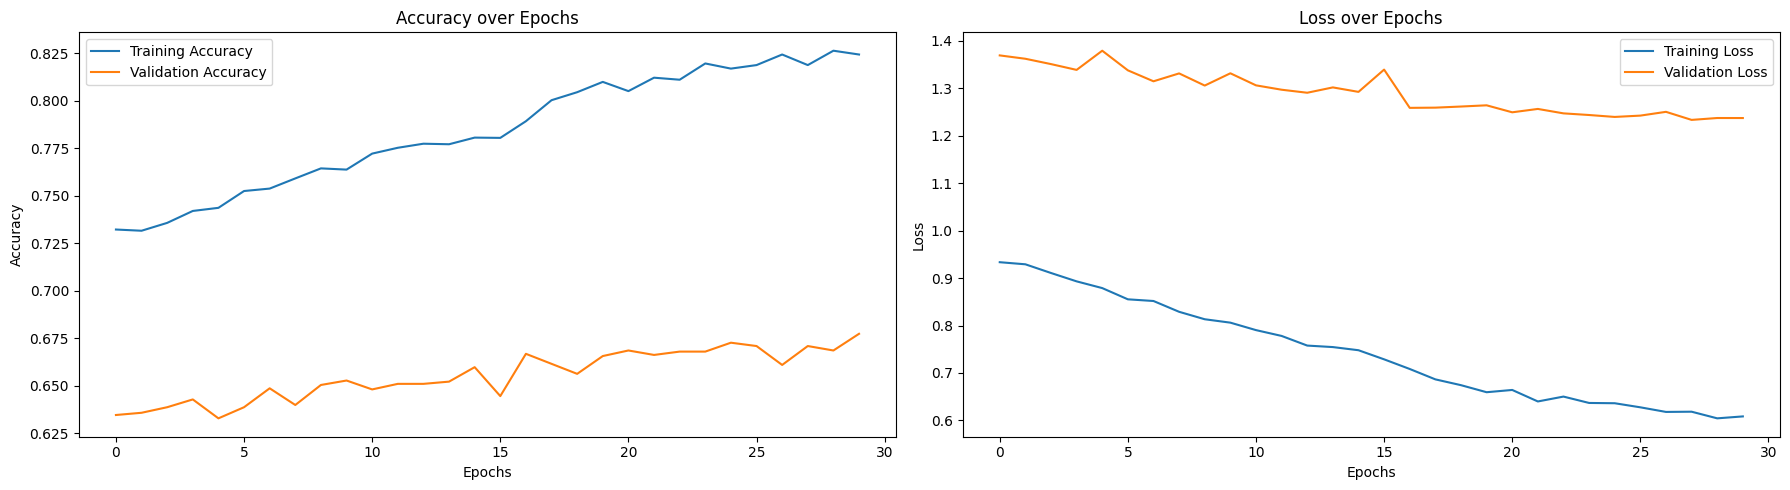

In [ ]:
plot_training_history(history_3.history)

In [ ]:
# Load best model (Epoch 5's weights)
model = tf.keras.models.load_model(r"..\models\best_model.h5")

In [ ]:
# Unfreeze the last 75 layers
for layer in model.layers[-75:]:  
    layer.trainable = True

# Compile the model again
model.compile(optimizer=Adam(learning_rate=3e-5),  
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 True
1 conv2d_188 False
2 batch_normalization_190 False
3 activation_188 False
4 conv2d_189 False
5 batch_normalization_191 False
6 activation_189 False
7 conv2d_190 False
8 batch_normalization_192 False
9 activation_190 False
10 max_pooling2d_8 False
11 conv2d_191 False
12 batch_normalization_193 False
13 activation_191 False
14 conv2d_192 False
15 batch_normalization_194 False
16 activation_192 False
17 max_pooling2d_9 False
18 conv2d_196 False
19 batch_normalization_198 False
20 activation_196 False
21 conv2d_194 False
22 conv2d_197 False
23 batch_normalization_196 False
24 batch_normalization_199 False
25 activation_194 False
26 activation_197 False
27 average_pooling2d_18 False
28 conv2d_193 False
29 conv2d_195 False
30 conv2d_198 False
31 conv2d_199 False
32 batch_normalization_195 False
33 batch_normalization_197 False
34 batch_normalization_200 False
35 batch_normalization_201 False
36 activation_193 False
37 activation_195 False
38 activation_198 False
39 activation_

In [ ]:
history_4 = train_model(model, train_gen, val_gen,class_weights=class_weights_dict, epochs=20)      

Epoch 1/20
438/438 [==============================] - ETA: 0s - loss: 1.4454 - accuracy: 0.5857
Epoch 1: val_loss improved from inf to 1.57700, saving model to ..\models\best_model.h5
438/438 [==============================] - 924s 2s/step - loss: 1.4454 - accuracy: 0.5857 - val_loss: 1.5770 - val_accuracy: 0.6001 - lr: 3.0000e-05
Epoch 2/20
438/438 [==============================] - ETA: 0s - loss: 1.1141 - accuracy: 0.6665
Epoch 2: val_loss improved from 1.57700 to 1.40249, saving model to ..\models\best_model.h5
438/438 [==============================] - 619s 1s/step - loss: 1.1141 - accuracy: 0.6665 - val_loss: 1.4025 - val_accuracy: 0.6370 - lr: 3.0000e-05
Epoch 3/20
438/438 [==============================] - ETA: 0s - loss: 0.9772 - accuracy: 0.7033
Epoch 3: val_loss improved from 1.40249 to 1.37177, saving model to ..\models\best_model.h5
438/438 [==============================] - 582s 1s/step - loss: 0.9772 - accuracy: 0.7033 - val_loss: 1.3718 - val_accuracy: 0.6487 - lr: 3.00

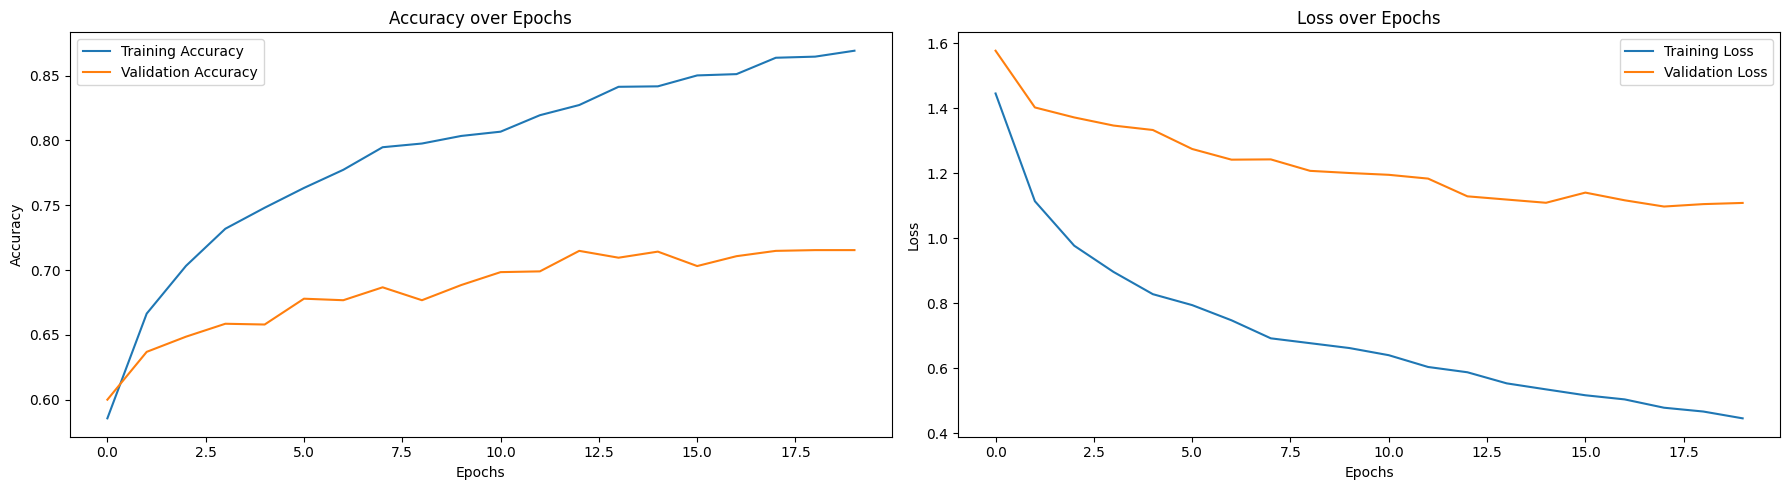

In [ ]:
plot_training_history(history_4.history)

In [ ]:
# we have four history objects: history, history_2, history_3, history_4 ]
histories = [ history_1 ,history_2, history_3, history_4]
combined_history = pd.DataFrame()

for h in histories:
    temp_df = pd.DataFrame({
        'epoch': range(len(h.history['accuracy'])),
        'loss': h.history['loss'],
        'accuracy': h.history['accuracy'],
        'val_loss': h.history['val_loss'],
        'val_accuracy': h.history['val_accuracy']
    })
    combined_history = pd.concat([combined_history, temp_df], ignore_index=True)

combined_history.to_csv('combined_history.csv', index=False)

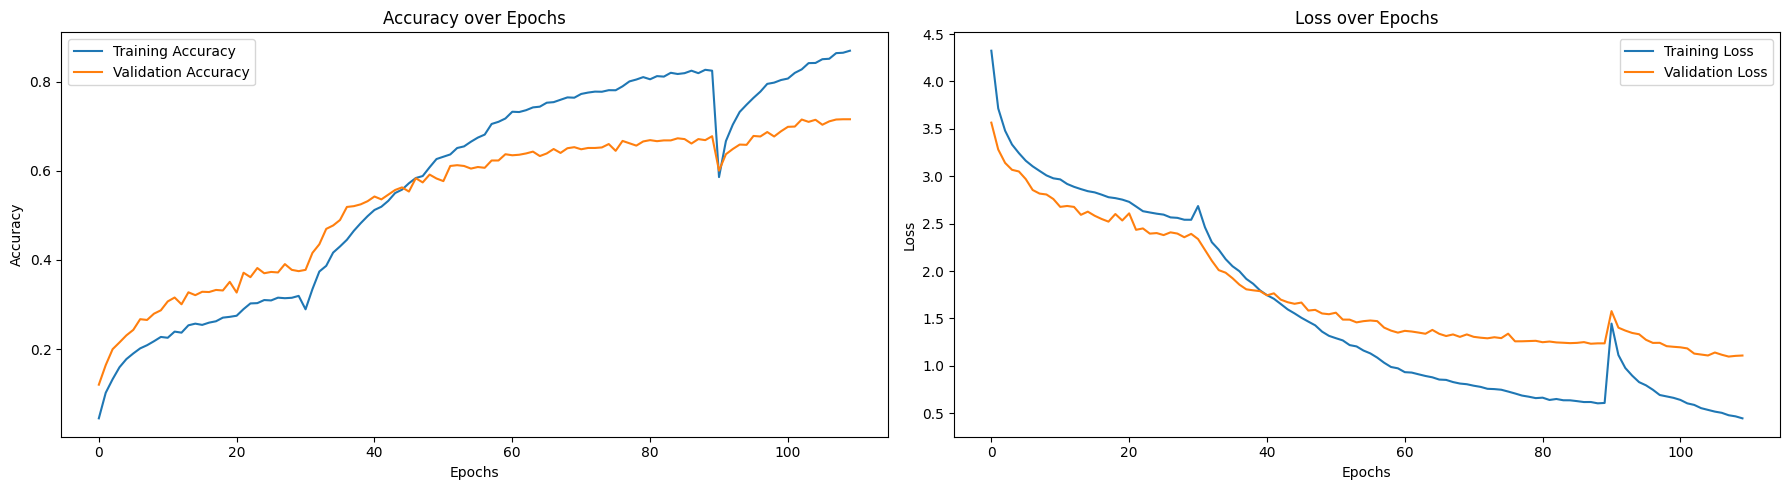

In [ ]:
plot_training_history(combined_history)

# Evaluate our model  :

In [240]:
model = tf.keras.models.load_model(r"..\models\best_model.h5")

In [242]:
model.evaluate(val_gen)

54/54 [==============================] - 24s 447ms/step - loss: 1.0132 - accuracy: 0.7377


[1.0131820440292358, 0.7377049326896667]

In [241]:
model.evaluate(test_gen)

58/58 [==============================] - 17s 254ms/step - loss: 1.1981 - accuracy: 0.7070


[1.198075532913208, 0.7069616913795471]

In [243]:
# Get true labels
y_true = test_gen.labels  # This gives class indices

display(y_true.shape)

(1853,)

In [244]:
#Get Predictions from Model
predictions = model.predict(test_gen)

58/58 [==============================] - 14s 209ms/step


In [111]:
#Get Predictions from Model
predictions = model.predict(test_gen)

58/58 [==============================] - 16s 209ms/step


In [259]:
predictions.shape

(1853, 105)

In [260]:
# Convert probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

In [261]:
#Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

In [263]:
# save them a Data frame:
metrics_df = pd.DataFrame({
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1-score": [f1]
})

metrics_df.to_csv("evaluation_metrics.csv", index=False)
print("Metrics saved as evaluation_metrics.csv....")

display(metrics_df)

Metrics saved as evaluation_metrics.csv....


,Accuracy,Precision,Recall,F1-score
0,0.706962,0.726194,0.711508,0.710204


In [264]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.41      0.58        22
           1       0.53      0.60      0.56        15
           2       0.90      0.83      0.86        23
           3       0.88      0.93      0.90        15
           4       0.75      0.92      0.83        13
           5       0.83      0.71      0.77        21
           6       0.75      0.57      0.65        21
           7       0.82      1.00      0.90        14
           8       0.83      0.88      0.86        17
           9       0.82      0.64      0.72        14
          10       0.86      0.92      0.89        13
          11       0.85      0.73      0.79        15
          12       0.88      0.64      0.74        22
          13       0.57      0.36      0.44        11
          14       0.57      0.47      0.52        17
          15       0.79      0.61      0.69        18
          16       0.88      0.94      0.91        16
          17       0.71    

In [265]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

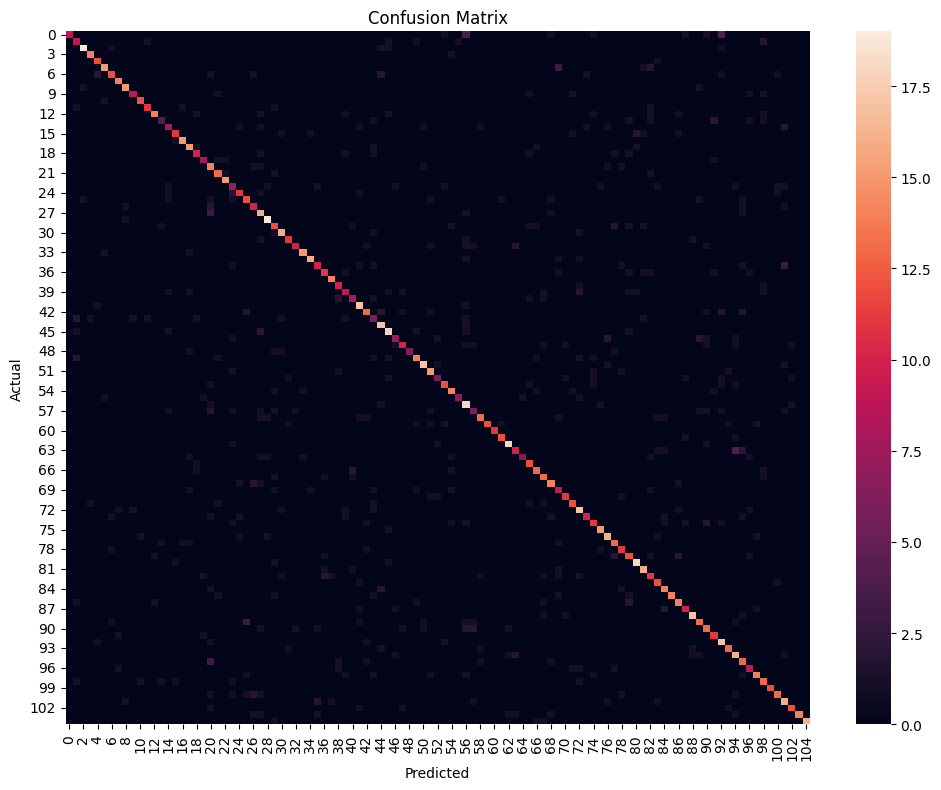

In [266]:
# Plot Confusion Matrix
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, fmt=None, cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def show_prediction_samples(model, test_data, class_names, num_samples=6):
    # Get a batch from the test generator
    images, labels = next(iter(test_data))  # Get the first batch

    labels = np.argmax(labels, axis=1)

    # Make predictions using the model
    y_pred = model.predict(images)  # Get predictions for the batch
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels

    correct = []
    incorrect = []

    # Iterate through the first batch and compare true and predicted labels
    for i in range(len(images)):
        if len(correct) >= num_samples and len(incorrect) >= num_samples:
            break

        img = images[i]
        img = ((img + 1) / 2)*255 
        true_label, pred_label = labels[i], y_pred_classes[i]


        if true_label == pred_label and len(correct) < num_samples:
            correct.append((img, true_label, pred_label))
        elif true_label != pred_label and len(incorrect) < num_samples:
            incorrect.append((img, true_label, pred_label))

    # Plot images
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

    for i in range(num_samples):
        # Correct predictions
        img, true_label, pred_label = correct[i]
        axes[0, i].imshow(img.astype("uint8"))
        axes[0, i].set_title(f"{class_names[true_label]}")
        axes[0, i].axis("off")

        # Incorrect predictions
        img, true_label, pred_label = incorrect[i]
        axes[1, i].imshow(img.astype("uint8"))
        axes[1, i].set_title(f"{class_names[pred_label]} (True: {class_names[true_label]})", fontsize=8, color="red")
        axes[1, i].axis("off")

    plt.suptitle("(preprocessed images) ---> Correct (Top) & Incorrect (Bottom) Predictions", fontsize=14, fontweight="bold")
    plt.show()


1/1 [==============================] - 0s 93ms/step


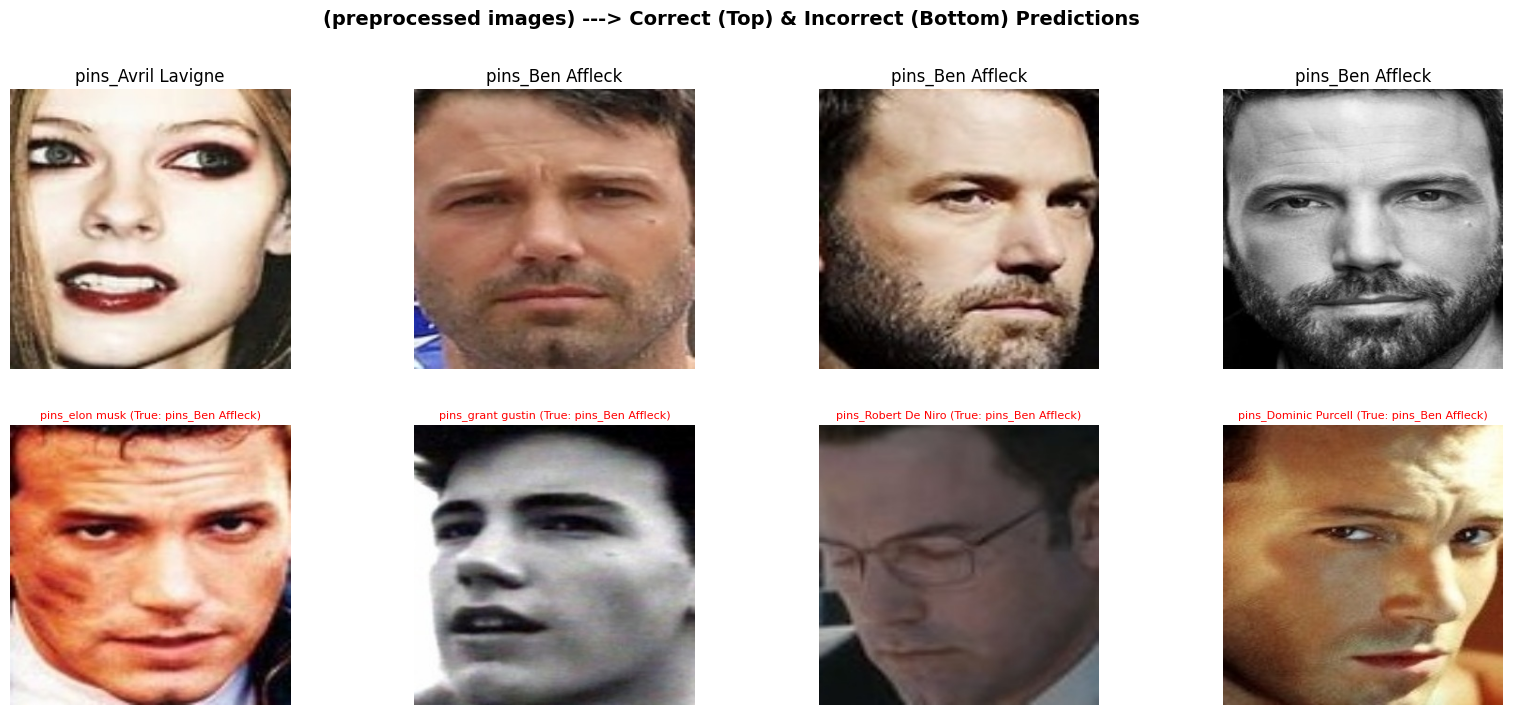

In [231]:
show_prediction_samples(model, test_gen, class_names, num_samples=4)

# 🎯 **Extract feature embeddings from the trained model for similarity-based recognition.** 🔍
---


> prepare our ONNX model 

In [1]:
import sys
sys.path.append("..")  # Go up one level to access `src/`

In [2]:
from tqdm.notebook import tqdm


In [3]:
from src.inference  import FaceRecognitionInference  
import cv2
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
onnx_model_path = r'..\models\face_recognition.onnx'

In [23]:
# Initialize the FaceRecognitionInference class for ONNX model
onnx_inference = FaceRecognitionInference(onnx_model_path, model_type="onnx")

In [6]:
def create_embedding_generator(data_dir, img_size=(299, 299), batch_size=32):
    """
    Creates a data generator without augmentation or preprocessing for feature extraction.
    This generator will only load and resize images for embedding extraction.
    """
    datagen = ImageDataGenerator()  # No augmentation or preprocessing

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",  
        shuffle=False  
    )


    print(f"✅ Data generator created for embedding extraction: {data_dir}")
    return generator

In [19]:
train_embedding_gen = create_embedding_generator(TRAIN_DIR, img_size=(299, 299), batch_size=64)

Found 14015 images belonging to 105 classes.
✅ Data generator created for embedding extraction: ..\data\processed\split_faces\train


In [20]:
with open(r"../models/labels.json", 'r') as f:
    class_names = json.load(f)  # List of 105 class names

In [21]:
class_names

{'0': 'pins_Adriana Lima',
 '1': 'pins_Alex Lawther',
 '2': 'pins_Alexandra Daddario',
 '3': 'pins_Alvaro Morte',
 '4': 'pins_Amanda Crew',
 '5': 'pins_Andy Samberg',
 '6': 'pins_Anne Hathaway',
 '7': 'pins_Anthony Mackie',
 '8': 'pins_Avril Lavigne',
 '9': 'pins_Ben Affleck',
 '10': 'pins_Bill Gates',
 '11': 'pins_Bobby Morley',
 '12': 'pins_Brenton Thwaites',
 '13': 'pins_Brian J. Smith',
 '14': 'pins_Brie Larson',
 '15': 'pins_Chris Evans',
 '16': 'pins_Chris Hemsworth',
 '17': 'pins_Chris Pratt',
 '18': 'pins_Christian Bale',
 '19': 'pins_Cristiano Ronaldo',
 '20': 'pins_Danielle Panabaker',
 '21': 'pins_Dominic Purcell',
 '22': 'pins_Dwayne Johnson',
 '23': 'pins_Eliza Taylor',
 '24': 'pins_Elizabeth Lail',
 '25': 'pins_Emilia Clarke',
 '26': 'pins_Emma Stone',
 '27': 'pins_Emma Watson',
 '28': 'pins_Gwyneth Paltrow',
 '29': 'pins_Henry Cavil',
 '30': 'pins_Hugh Jackman',
 '31': 'pins_Inbar Lavi',
 '32': 'pins_Irina Shayk',
 '33': 'pins_Jake Mcdorman',
 '34': 'pins_Jason Momoa',
 

> lets create our embeddings matrix and labels for it

In [24]:
def extract_embeddings_from_generator(model, data_gen):
    """
    Extracts embeddings from the data generator for all images with a progress bar.
    """
    embeddings = []
    labels = []

    # Initialize tqdm progress bar with the total number of batches
    pbar = tqdm(total=data_gen.samples // data_gen.batch_size, desc="Extracting embeddings", ncols=218)

    for batch_images, batch_labels in data_gen: 
        # Loop through each image in the batch
        for img, label in zip(batch_images, batch_labels):
            # Compute the embedding for the single image
            embedding = model.compute_embedding(img)
            embeddings.append(embedding.flatten())  # Flatten to ensure proper shape
            labels.append(np.argmax(label))  # Get the class index

        # Update progress bar
        pbar.update(1)

        # Stop if all batches are processed
        if len(embeddings)  >= data_gen.samples:
            break

    # Close the progress bar once done
    pbar.close()

    # Convert list of embeddings and labels to numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    return embeddings, labels


In [25]:
embeddings_matrix , labels_embedding = extract_embeddings_from_generator(model = onnx_inference, data_gen = train_embedding_gen)

Extracting embeddings:   0%|                                                                                  …

In [ ]:
display(embeddings_matrix.shape)

(14015, 128)

In [58]:
display(labels_embedding.shape)

(14015,)

> test with image

In [27]:
sample_img_path_2 = r"C:\Users\Electronica\Desktop\image_2.jpg"

In [28]:
img = cv2.imread(sample_img_path_2)

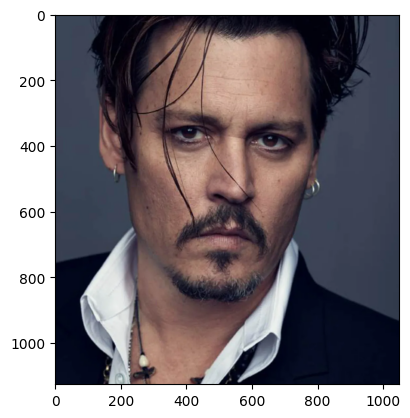

In [243]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [29]:
sample_embedding = onnx_inference.compute_embedding(img)

In [30]:
sample_embedding_re = sample_embedding.reshape(1, -1)  # Reshape for cosine_similarity

#  avg embeddings :

In [246]:
def average_embeddings_by_label(embeddings, labels):
    """
    Averages embeddings for each label and returns a matrix for cosine similarity.
    """
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Create an empty list to store the averaged embeddings
    averaged_embeddings = []
    
    # Iterate over each label
    for label in unique_labels:
        # Find all embeddings for the current label
        label_embeddings = embeddings[labels == label]
        
        # Compute the average embedding for the current label
        averaged_embedding = np.mean(label_embeddings, axis=0)
        
        # Append the averaged embedding to the list
        averaged_embeddings.append(averaged_embedding)
    
    # Convert list to numpy array for matrix operations
    averaged_embeddings_matrix = np.array(averaged_embeddings)
    
    return averaged_embeddings_matrix, unique_labels


In [247]:
averaged_embeddings_matrix, unique_labels = average_embeddings_by_label(embeddings_matrix , labels_embedding)

> test

In [ ]:
def get_top_k_similar_labels(query_embedding, embeddings_matrix, unique_labels,class_names, k=3):
    """
    Finds the top-k most similar labels based on cosine similarity.
    """
    # Compute cosine similarity between the query embedding and all averaged embeddings
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), embeddings_matrix)

    # Get the indices of the top-k highest similarity scores
    top_k_indices = np.argsort(similarity_scores[0])[::-1][:k]

    # Get the top-k labels and similarity scores
    top_k_labels = [class_names[str(unique_labels[i])] for i in top_k_indices]
    top_k_scores = [similarity_scores[0][i] for i in top_k_indices]


    label_score_pairs = list(zip(top_k_labels, top_k_scores))

    return label_score_pairs


In [260]:
get_top_k_similar_labels(sample_embedding_re,averaged_embeddings_matrix,unique_labels,class_names = class_names,k= 6)

[('pins_Brenton Thwaites', 0.8172574),
 ('pins_Brian J. Smith', 0.81633),
 ('pins_Johnny Depp', 0.778674),
 ('pins_Bobby Morley', 0.77444136),
 ('pins_Leonardo DiCaprio', 0.74525315),
 ('pins_Zac Efron', 0.74319804)]

>save 

In [32]:
import numpy as np

def save_avg_embeddings_npz(embeddings, labels, filename="avg_embeddings.npz"):
    """
    Saves the averaged embeddings and labels in a compressed .npz format.
    """
    np.savez_compressed(filename, embeddings=embeddings, labels=np.array(labels))
    print(f"✅ Saved embeddings and labels to {filename}")



In [254]:
# Save embeddings
save_avg_embeddings_npz(averaged_embeddings_matrix, unique_labels,filename= r"..\models\avg_embeddings.npz")

✅ Saved embeddings and labels to ..\models\avg_embeddings.npz


In [33]:
#save the full version  of embedding:
save_avg_embeddings_npz(embeddings_matrix, labels_embedding,filename= r"..\models\full_embeddings.npz")   

✅ Saved embeddings and labels to ..\models\full_embeddings.npz


In [251]:
def load_avg_embeddings_npz(filename="avg_embeddings.npz"):
    """
    Loads the averaged embeddings and labels from a .npz file.
    """
    data = np.load(filename, allow_pickle=True)
    embeddings = data["embeddings"]
    labels = data["labels"].tolist()  # Convert back to list

    print(f"✅ Loaded {len(labels)} labels with shape: {embeddings.shape}")
    return embeddings, labels

